# Assignment-1

**Group:** \
Kerman Zaveri (22570009)\
Chestha ()

Importing libraries

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from typing import Union,Literal # for bas & utils
from dataclasses import dataclass # for base

from sklearn.datasets import make_classification # for test_train split
### for auto efficiency
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

### for time complexity
import time
import scienceplots
plt.style.use(['science','notebook','grid']) # To make plot looks better

## Q1 Decision Tree Implementation

### Q1(i) Complete the decision tree implementation 

#### metrics.py

In [8]:
def accuracy(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the accuracy
    """

    """
    The following assert checks if sizes of y_hat and y are equal.
    Students are required to add appropriate assert checks at places to
    ensure that the function does not fail in corner cases.
    """
    assert y_hat.size == y.size
    
    return (y_hat == y).sum() / y.size


def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the precision
    """
    assert y_hat.size == y.size

    TP= ((y==cls) & (y_hat==cls)).sum() # Counting True Positive cases
    FP= ((y!=cls) & (y_hat==cls)).sum() # Counting False Positive cases
    if TP+FP==0:
        return f'N/A, TP+TF=0'
    else:
        return TP/(TP+FP)


def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the recall
    """
    assert y_hat.size == y.size
    
    TP= ((y==cls) & (y_hat==cls)).sum() # Counting True Positive cases
    FN= ((y==cls) & (y_hat!=cls)).sum() # Counting False Negative cases
    if TP+FN==0:
        return 'N/A TP+FN=0'
    else:
        return TP/(TP+FN)


def rmse(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the root-mean-squared-error(rmse)
    """
    assert y_hat.size == y.size

    return np.sqrt(((y - y_hat) ** 2).mean()) #RMSE formula


def mae(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the mean-absolute-error(mae)
    """
    assert y_hat.size == y.size

    return (y - y_hat).abs().mean() #MAE formula

#### utils.py

In [9]:
def one_hot_encoding(X: pd.DataFrame) -> pd.DataFrame:
    """
    Function to perform one hot encoding on the input data
    """
    return pd.get_dummies(X)


def check_ifreal(y: pd.Series) -> bool:
    """
    Function to check if the given series has real or discrete values
    """
    # Check if it's numeric
    if not pd.api.types.is_numeric_dtype(y):
        return False
    
    # Check if it's boolean or categorical, it's classification
    if pd.api.types.is_bool_dtype(y) or isinstance(y.dtype, pd.CategoricalDtype):
        return False
    
    # Get unique values
    unique_vals = y.unique()
    n_unique = len(unique_vals) #coounting unique values
    
    # Check for binary classification (0 or 1 type data)
    if n_unique <= 2:
        return False
    
    # If there are very few unique values relative to the total number of samples then it's likely classification case
    unique_ratio = n_unique / len(y) # checking the ratio of unique values
    if unique_ratio < 0.25:  # Less than 25% unique values suggests classification, valaue is choosen arbitarily
        return False
    
    return True  # If none of the above conditions are met, assume regression
    


def entropy(Y: pd.Series) -> float:
    """
    Function to calculate the entropy
    """
    p=Y.value_counts(normalize=True)
    p = p[p > 0] # Removing zero probabilities to avoid log2(0)
    return -(p*np.log2(p)).sum() #Entropy formula


def gini_index(Y: pd.Series) -> float:
    """
    Function to calculate the gini index
    """
    p=Y.value_counts(normalize=True)
    return 1-(p**2).sum() #Gini index formula


def mse(Y: pd.Series) -> float:
    """
    Function to calculate the mean squared error
    """
    return ((Y - Y.mean()) ** 2).mean()  # MSE formula


def information_gain(Y: pd.Series, attr: pd.Series, criterion: Union[str, None]) -> float:
    """
    Function to calculate the information gain using criterion (entropy, gini index or MSE)
    Here, calculating information gain when attribute is discreate
    For real-valued attribute, calculation is done in the function opt_split_attribute 
    """
    assert criterion in ['information_gain', 'gini_index', None],f"Expecting 'information_gain' or 'gini_index' for classification and {None} for regeresion, got {criterion} instead"
    assert Y.size == attr.size, f'Size of Y and attribute is not same' # makes sure that Y and attr are of same size

    Y_len = len(Y)
    weighted_entropy = 0
    weighted_gini=0
    weighted_mse = 0

    if check_ifreal(Y): # regression
        Y_mse = mse(Y)
        for v in attr.unique():
            Y_sub = Y[attr == v]
            weighted_mse += (len(Y_sub) / Y_len) * mse(Y_sub)
        return Y_mse - weighted_mse #MSE reduction formula
    else: 
        if criterion=='information gain': # classification with information gain
            for v in attr.unique():
                Y_sub = Y[attr == v]
                weighted_entropy += (len(Y_sub) / Y_len) * entropy(Y_sub)
            return entropy(Y) - weighted_entropy #Information gain formula
        else: #classification with gini index
            for v in attr.unique():
                Y_sub = Y[attr == v]
                weighted_gini += (len(Y_sub) / Y_len) * gini_index(Y_sub)
            return  gini_index(Y) - weighted_gini

def opt_split_attribute(X: pd.DataFrame, y: pd.Series, criterion:Union[str,None], features: pd.Series):
    """
    Function to find the optimal attribute to split about.
    If needed you can split this function into 2, one for discrete and one for real valued features.
    You can also change the parameters of this function according to your implementation.

    features: pd.Series is a list of all the attributes we have to split upon

    return: attribute to split upon and the value of that attribute to split upon
    """
    
    assert criterion in ['information_gain', 'gini_index', None],f"Expecting 'entropy' or 'gini':for classification and {None} for regeresion, got {criterion} instead"

    best_attr = None
    best_score = -float('inf') # starting with the lowest possible value because if all gains are negative still want to return the best one
    best_val = None

    for attr in features:
        col = X[attr]

        if check_ifreal(col): #real-valued feature
            unique_vals = np.sort(col.unique())
            if len(unique_vals) <= 1: #skiping features with only one unique value
                continue
            
            # midpoints between consecutive values as potential splits
            potential_splits = [(unique_vals[i] + unique_vals[i+1]) / 2 for i in range(len(unique_vals) - 1)]

            for t in potential_splits: #calculating score for each potential split and choosing the best one
                left= col <= t
                right= col > t
                left_y, right_y = y[left], y[right]

                if len(left_y) == 0 or len(right_y) == 0: # skiping splits that result in empty nodes
                    continue

                if check_ifreal(y):  # regression problem, so use MSE reduction
                    score = mse(y) - (len(left_y)/len(y))*mse(left_y) - (len(right_y)/len(y))*mse(right_y)
                else:  # classification, so use information gain or gini gain
                    if criterion == "information_gain":
                        score = entropy(y) - (len(left_y)/len(y))*entropy(left_y) - (len(right_y)/len(y))*entropy(right_y)
                    else:
                        score = gini_index(y) - (len(left_y)/len(y))*gini_index(left_y) - (len(right_y)/len(y))*gini_index(right_y)

                if score > best_score:
                    best_score, best_attr, best_val = score, attr, t
        else: # discreate features
            score = information_gain(y, col, criterion)
            if score > best_score:
                best_score, best_attr, best_val = score, attr, None

    return best_attr, best_val


def split_data(X: pd.DataFrame, y: pd.Series, attribute, value):
    """
    Funtion to split the data according to an attribute.
    If needed you can split this function into 2, one for discrete and one for real valued features.
    You can also change the parameters of this function according to your implementation.

    attribute: attribute/feature to split upon
    value: value of that attribute to split upon

    return: splitted data(Input and output)
    """
    col = X[attribute]
    if check_ifreal(col) and value is not None: #split in left and right for real-valued feature
        left = col <= value
        right = col > value
        return (X[left], y[left]), (X[right], y[right])
    else:  #split in multiple vaues for discrete feature 
        splits = {}
        for v in col.unique():
            mask = col == v
            splits[v] = (X[mask], y[mask])
        return splits

####  base.py

In [10]:
class Node:
    def __init__(self, is_leaf=False, prediction=None,
                 feature=None, threshold=None, children=None):
        self.is_leaf = is_leaf # check if the node is a leaf node
        self.prediction = prediction # prediction value for leaf nodes
        self.feature = feature # feature to split upon
        self.threshold = threshold # threshold for real-valued feature
        self.children = children or {}  # dict for categorical or {left,right} for real


@dataclass
class DecisionTree:
    criterion: Literal["entropy", "gini_index",None]  # criterion won't be used for regression
    max_depth: int  # The maximum depth the tree can grow to

    def __init__(self, criterion, max_depth):
        self.criterion = criterion 
        self.max_depth = max_depth 
        self.root = None # root node of the tree
        self.is_regression = None #check if target is regression or classification

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """
         Function to train and construct the decision tree
        """
        self.is_regression = check_ifreal(y) # checking if target is regression or classification
        features = X.columns #list of all features
        self.root = self._build(X, y, features, depth=0) #building the tree

    def _build(self, X, y, features, depth):
        if len(y) == 0: # no samples
            return None

        # stop when max depth reached or pure leaf
        if depth >= self.max_depth or len(y.unique()) == 1:
            prediction = round(y.mean(),4) if self.is_regression else y.mode()[0] # mean for regression, mode for classification
            return Node(is_leaf=True, prediction=prediction)

        # choose best attribute
        attr, val = opt_split_attribute(X, y, self.criterion, features)
        if attr is None: # no valid split found
            prediction = round(y.mean(),4) if self.is_regression else y.mode()[0]
            return Node(is_leaf=True, prediction=prediction)

        # numeric feature gives binary split (left & right)
        if val is not None: 
            (X_left, y_left), (X_right, y_right) = split_data(X, y, attr, val)
            left_child = self._build(X_left, y_left, features, depth + 1) # recurse for left child
            right_child = self._build(X_right, y_right, features, depth + 1) # recurse for right child
            return Node(feature=attr, threshold=val, children={"left": left_child, "right": right_child})

        # categorical feature give multiple split depending on number of unique values
        else:
            splits = split_data(X, y, attr, None)
            children = {}
            for v, (X_sub, y_sub) in splits.items(): # recurse for each split
                children[v] = self._build(X_sub, y_sub, features, depth + 1)
            return Node(feature=attr, children=children)

    def predict(self, X: pd.DataFrame) -> pd.Series: # predicting for multiple rows
        preds = []
        for _, row in X.iterrows(): # iterating over each row
            preds.append(self._predict_row(row, self.root)) # predicting for each row
        return pd.Series(preds, index=X.index)

    def _predict_row(self, row, node: Node):
        if node.is_leaf:
            return node.prediction # return prediction at leaf

        if node.threshold is not None:  # numeric split
            if row[node.feature] <= node.threshold: # go left
                return self._predict_row(row, node.children["left"])
            else: # go right
                return self._predict_row(row, node.children["right"])
        else:  # categorical split
            val = row[node.feature] # get feature value
            if val in node.children: # if value seen during training
                return self._predict_row(row, node.children[val]) 
            else:
                # unseen category then fallback to majority prediction
                return node.prediction

    def plot(self) -> None:
        """
        Function to plot the tree

        Output Example:
        ?(X1 > 4)
            Y: ?(X2 > 7)
                Y: Class A
                N: Class B
            N: Class C
        Where Y => Yes and N => No
        """
        self._print_tree(self.root)

    def _print_tree(self, node: Node, depth=0):
        indent = "    " * depth
        if node is None: # empty node
            print(f"{indent}[Empty Node]")
            return

        if node.is_leaf: # leaf node
            if isinstance(node.prediction, float): # for regression
                pred_str = f"{node.prediction:.4f}"
            else: # for classification
                pred_str = str(node.prediction)
            print(f"{indent}Predict -> {pred_str}")

        elif node.threshold is not None:  # numeric feature
            print(f"{indent}?({node.feature} <= {node.threshold:.4f})")
            print(f"{indent}Y:")
            self._print_tree(node.children["left"], depth + 1)
            print(f"{indent}N:")
            self._print_tree(node.children["right"], depth + 1)

        else:  # categorical feature
            print(f"{indent}?({node.feature})")
            for v, child in node.children.items():
                print(f"{indent}{v}:")
                self._print_tree(child, depth + 1)

#### Checking the implementation

Test case 1: Real Input & Real Output

In [11]:
np.random.seed(42)

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P),columns=[f"X{i+1}" for i in range(P)])
y = pd.Series(np.random.randn(N))



tree = DecisionTree(criterion=None,max_depth=5)  # Split based on MSE reduction
tree.fit(X, y)
y_hat = tree.predict(X)
tree.plot()
#print("Criteria :", 'MSE')
print("RMSE: ", round(rmse(y_hat, y),4))
print(f"MAE: ", round(mae(y_hat, y),4))

?(X2 <= -1.1940)
Y:
    Predict -> 2.7202
N:
    ?(X5 <= 0.3866)
    Y:
        ?(X1 <= 1.5078)
        Y:
            ?(X5 <= -1.7440)
            Y:
                ?(X2 <= 0.8125)
                Y:
                    Predict -> 0.5347
                N:
                    Predict -> 0.9634
            N:
                ?(X3 <= 1.2407)
                Y:
                    Predict -> -0.3460
                N:
                    Predict -> 0.8221
        N:
            ?(X1)
            2.1904556258099785:
                Predict -> 0.8272
            1.5499344050175394:
                Predict -> 1.4535
    N:
        ?(X1 <= -0.3567)
        Y:
            ?(X1 <= -0.4905)
            Y:
                ?(X1)
                -0.6017066122293969:
                    Predict -> 1.8658
                -0.5017570435845365:
                    Predict -> 1.8968
            N:
                Predict -> 1.1586
        N:
            ?(X5 <= 1.0033)
            Y:
                ?(

Test case 4: Discrete Input and Real Output

In [12]:
np.random.seed(42)

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in [f"X{i+1}" for i in range(5)]})
y = pd.Series(np.random.randn(N))

tree = DecisionTree(criterion=None,max_depth=5)  # Split based on MSE reduction
tree.fit(X, y)
y_hat = tree.predict(X)
tree.plot()
#print("Criteria :", 'MSE')
print("RMSE: ", round(rmse(y_hat, y),4))
print(f"MAE: ", round(mae(y_hat, y),4))

?(X5)
1:
    ?(X2)
    2:
        Predict -> 0.7241
    4:
        Predict -> -0.8225
    1:
        Predict -> 1.0867
    3:
        Predict -> -0.7626
3:
    ?(X1)
    4:
        ?(X3)
        3:
            Predict -> -0.2558
        4:
            Predict -> 0.3013
    1:
        Predict -> -0.5066
    2:
        ?(X2)
        4:
            Predict -> 2.9437
        0:
            Predict -> 1.9746
        3:
            Predict -> 1.9650
    3:
        ?(X3)
        0:
            Predict -> -0.8460
        4:
            Predict -> 1.2370
        2:
            Predict -> 0.1687
    0:
        ?(X2)
        4:
            Predict -> -1.4265
        2:
            Predict -> 0.3380
4:
    ?(X4)
    2:
        ?(X1)
        2:
            Predict -> 0.8499
        3:
            Predict -> 1.0050
        4:
            Predict -> -0.0842
    4:
        Predict -> -1.3100
    1:
        ?(X1)
        2:
            Predict -> -1.0963
        1:
            Predict -> -1.4585
    0:

Test case 2: Real Input and Discrete Output

In [13]:
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P),columns=[f"X{i+1}" for i in range(P)])
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria,max_depth=5)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print(f"Class:{cls}:")
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))

?(X3 <= 0.7486)
Y:
    ?(X4 <= -0.4588)
    Y:
        ?(X1 <= 0.5869)
        Y:
            ?(X3 <= -0.5711)
            Y:
                Predict -> 0
            N:
                Predict -> 3
        N:
            ?(X3 <= -0.6670)
            Y:
                Predict -> 3
            N:
                ?(X1 <= 0.6530)
                Y:
                    Predict -> 4
                N:
                    Predict -> 1
    N:
        ?(X1 <= -0.6674)
        Y:
            ?(X2 <= 0.3682)
            Y:
                Predict -> 1
            N:
                Predict -> 0
        N:
            ?(X1 <= 0.4708)
            Y:
                ?(X1 <= -0.1675)
                Y:
                    Predict -> 4
                N:
                    Predict -> 0
            N:
                ?(X4 <= 0.4495)
                Y:
                    Predict -> 2
                N:
                    Predict -> 4
N:
    ?(X1 <= 0.8603)
    Y:
        Predict -> 2
    N:
       

Test case 3: Discrete Input and Discrete Output

In [14]:
N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in [f"X{i+1}" for i in range(5)]})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria,max_depth=5)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print(f"Class:{cls}:")
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))

?(X5)
3:
    ?(X1)
    0:
        ?(X4)
        2:
            Predict -> 0
        0:
            Predict -> 3
        1:
            Predict -> 0
    1:
        Predict -> 3
    2:
        Predict -> 1
    3:
        Predict -> 0
    4:
        Predict -> 2
4:
    ?(X3)
    0:
        Predict -> 0
    3:
        ?(X1)
        1:
            Predict -> 2
        4:
            Predict -> 3
    1:
        Predict -> 3
    4:
        Predict -> 1
    2:
        ?(X1)
        3:
            Predict -> 3
        0:
            Predict -> 1
0:
    ?(X3)
    3:
        Predict -> 4
    2:
        Predict -> 2
    0:
        Predict -> 1
    4:
        Predict -> 3
    1:
        ?(X1)
        1:
            Predict -> 4
        4:
            Predict -> 1
        2:
            Predict -> 4
2:
    ?(X4)
    4:
        Predict -> 0
    1:
        Predict -> 4
1:
    Predict -> 3
Criteria : information_gain
Accuracy:  1.0
Class:0:
Precision:  1.0
Recall:  1.0
Class:4:
Precision:  1.0
Recall: 

### Q1(ii) Testing the code & K-fold validation

In [27]:
## Generatting data-set
X, y = make_classification(
n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

##For plotting
#plt.scatter(X[:, 0], X[:, 1], c=y)

X = pd.DataFrame(X, columns=["X1", "X2"])
y = pd.Series(y)

#### (a) Testing the code

In [28]:
def train_test_split(X:pd.DataFrame, y:pd.Series, test_size:float, seed:int):
    """
    Function to split the data into train and test sets
    """
    assert 0 < test_size < 1, "test_size should be between 0 and 1"
    np.random.seed(seed)

    idx = np.arange(len(X)) # array of indices
    np.random.shuffle(idx) # shuffling the indices
    split = int( len(X)* (1 - test_size)) # calculating the split index
    train_idx, test_idx = idx[:split], idx[split:] # splitting the indices
    return X.iloc[train_idx], y.iloc[train_idx], X.iloc[test_idx], y.iloc[test_idx]

In [30]:
## train-test split
X_train,Y_train,X_test,y_test=train_test_split(X,y,test_size=0.3,seed=42)

## Training the decision tree
tree = DecisionTree(criterion="information_gain", max_depth=5)
tree.fit(X_train, Y_train)

y_pred=tree.predict(X_test) # Predicting on the test set


## Evaluating the model
print("Train Accuracy: ", round(accuracy(tree.predict(X_train), Y_train),4))
print("Test Accuracy: ", round(accuracy(y_pred, y_test),4))
for cls in y.unique():
    print(f"Class:{cls}:")
    print(f"Precision:{round(precision(y_pred, y_test, cls),4)}")
    print(f"Recall: ",round(recall(y_pred, y_test, cls),4))

Train Accuracy:  0.9714
Test Accuracy:  0.9333
Class:1:
Precision:0.9
Recall:  1.0
Class:0:
Precision:1.0
Recall:  0.8333


#### (b) 5 fold cross-validation & Nested cross-validation

5 fold cross-validation

In [31]:
def kfold_split(X:pd.DataFrame, y:pd.Series, k:int, seed:int):
    """
    Function to get indices for k-fold
    """
    assert k > 1, "k should be greater than 1"
    #assert len(y)%k==0, "Number of samples should be divisible by k"7

    np.random.seed(seed)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    fold_size = len(X) // k
    folds = [idx[i*fold_size:(i+1)*fold_size] for i in range(k)]
    return folds

In [32]:
folds = kfold_split(X, y, 5, seed=42) # getting the folds
all_idx = np.arange(len(X)) # array of all indices

acc_scores = [] # list to store accuracy for each fold

for _,test_idx in enumerate(folds,start=1): # iterating over each fold
    train_idx = np.setdiff1d(all_idx,test_idx) # getting train indices by removing test indices from all indices
    
    #Train-test split
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    # Training the decision tree
    tree = DecisionTree(criterion='information_gain', max_depth=5) 
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    acc_scores.append(accuracy(y_test,y_pred))

print(f"Mean Accuracy: {np.mean(acc_scores):.4f} at depth 5")

Mean Accuracy: 0.8800 at depth 5


Nested cross-validadtion

In [33]:
outer_k=5 #number outer folds
inner_k=5 #number inner folds
candidate_depths=np.array([1,2,3,4,5,6])
seed=42

outer_fold=kfold_split(X, y, k=outer_k, seed=seed) #outer fold
outer_scores,chosen_depths = [],[]
all_idx = np.arange(len(X)) #all indices of X

for _,test_idx in enumerate(outer_fold,start=1):
    tem_idx = np.setdiff1d(all_idx,test_idx) 
    #Test-temperory split
    X_tem,y_tem = X.iloc[tem_idx],y.iloc[tem_idx]
    X_test,y_test = X.iloc[test_idx],y.iloc[test_idx]

    best_depth,best_cv = None,-1

    # Inner CV to pick best depth
    for d in candidate_depths:
        inner_fold=kfold_split(X_tem,y_tem,inner_k,seed=42) #inner fold
        temp_ind=np.arange(len(X_tem)) # all indices of X_temp
        inner_score=[]

        for _,val_idx in enumerate(inner_fold,start=1): 
            train_idx = np.setdiff1d(tem_idx,val_idx) #validation incies
            
            #Train-validation split
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx] 
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
            
            #Tarining the tree
            tree = DecisionTree(criterion='information_gain', max_depth=d) 
            tree.fit(X_train, y_train)
            y_pred = tree.predict(X_val)

            inner_score.append(accuracy(y_val,y_pred))
        if np.mean(inner_score) > best_cv:
            best_cv,best_depth = np.mean(inner_score),d

    chosen_depths.append(best_depth)
    tree=DecisionTree(criterion="information_gain", max_depth=best_depth)
    tree.fit(X_tem,y_tem) #train on X_train+X_val set
    y_final_pred = tree.predict(X_test) #prediction of X_test set
    
    outer_scores.append(accuracy(y_final_pred, y_test))

print(f"Mean accuracy:{np.mean(outer_scores):.4f}|Depths choosen at each outer fold:{np.array(chosen_depths).astype(int)}")

Mean accuracy:0.9100|Depths choosen at each outer fold:[2 2 2 2 3]


### Q1(iii) Automotive efficiency problem

In [35]:
cols="displacement,cylinders,mpg,horsepower,weight,accelaration,model_year,origin,car_name".split(',')
df = pd.read_csv("auto-mpg.data", sep='\\s+', names=cols,na_values='?')
#display(df)

####Cleaning the data
#print(df.isna().sum()) #check how many NaN values are there
# Filing the NaN values with mean so it wont't effect the data, mean because horsepower is continuous feature not classification
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].mean())
#print(df.isna().sum()) # checking if that worked, should see 0 NaN

X_auto = df.drop(columns=["mpg","car_name"])
y_auto = df["mpg"]

#### Decision tree with self-made algorithm 

In [36]:
folds = kfold_split(X_auto, y_auto, 5, seed=42) # getting the folds
all_idx = np.arange(len(X_auto)) # array of all indices

rmse_self = [] # list to store RMSE for each fold
mae_self=[] # lsit to store MAE for each fold

for _,test_idx in enumerate(folds,start=1): # iterating over each fold
    train_idx = np.setdiff1d(all_idx,test_idx) # getting train indices by removing test indices from all indices
    
    #Train-test split
    X_auto_train, y_auto_train = X_auto.iloc[train_idx], y_auto.iloc[train_idx]
    X_auto_test, y_auto_test = X_auto.iloc[test_idx], y_auto.iloc[test_idx]
    
    # Make the decision tree with self made algorithm
    tree_self = DecisionTree(criterion=None, max_depth=5) 
    tree_self.fit(X_auto_train, y_auto_train)
    y_pred_self = tree_self.predict(X_auto_test)

    rmse_self.append(rmse(y_auto_test,y_pred_self))
    mae_self.append(mae(y_auto_test,y_pred_self))

print(f"at depth 5, Mean RMSE: {np.mean(rmse_self):.4f}|Mean MAE:{np.mean(mae_self):.4f} ")

at depth 5, Mean RMSE: 21.8796|Mean MAE:14.9712 


#### Decision tree using sklearn library

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_sk, rmse_sk = [], []

for train_idx, test_idx in kf.split(X_auto):
    Xauto_train, Xauto_test = X_auto.iloc[train_idx], X_auto.iloc[test_idx]
    yauto_train, yauto_test = y_auto.iloc[train_idx], y_auto.iloc[test_idx]

    # Make decision tree using sklearn library
    tree_sk = DecisionTreeRegressor(max_depth=5, random_state=42)
    tree_sk.fit(Xauto_train, yauto_train)
    y_pred_sk = tree_sk.predict(Xauto_test)

    mae_sk.append(mean_absolute_error(yauto_test, y_pred_sk))
    rmse_sk.append(np.sqrt(mean_squared_error(yauto_test, y_pred_sk)))

print(f"at depth 5, Mean RMSE: {np.mean(rmse_sk):.4f}|Mean MAE:{np.mean(mae_sk):.4f} ")

at depth 5, Mean RMSE: 21.7238|Mean MAE:14.8337 


As can be seen, the accuracy of both the models are very close, but the time taken for it is very large in case of self made algorithm comapare to sklearn. 

### Q1(iv) Time Complexity

#### Functions

In [38]:
# Function to create fake data (take inspiration from usage.py)
np.random.seed(42)
def generate_data(N, M, target="classification", feature_is_real=True):
    """
    N = number of samples
    M = number of features
    target = "classification" or "regression"
    feature_is_real = if True, generate continuous features; else discreate features
    """
    if feature_is_real:
        X = pd.DataFrame(np.random.randn(N, M),columns=[f"X{i+1}" for i in range(M)])
    else:
        X=pd.DataFrame({i: pd.Series(np.random.randint(2, size=N), dtype="category") for i in [f"X{i+1}" for i in range(M)]})

    if target == "classification":
        y = pd.Series(np.random.randint(2, size=N), dtype="category")
    else:
        y = pd.Series(np.random.randn(N))

    return X, y


# Function to calculate average time (and std) taken by fit() and predict() for different N and M for 4 different cases of DTs
def benchmark_tree(N_list, M_list, target='classification', feature_is_real=True,num_average_time=1):
    fit_times_avg = pd.DataFrame(index=N_list, columns=M_list, dtype=float)
    pred_times_avg = pd.DataFrame(index=N_list, columns=M_list, dtype=float)
    
    fit_times_std = pd.DataFrame(index=N_list, columns=M_list, dtype=float)
    pred_times_std = pd.DataFrame(index=N_list, columns=M_list, dtype=float)

    for M in M_list:
        for N in N_list:
            X, y = generate_data(N, M, target=target, feature_is_real=feature_is_real) #generating data
            if target=='classification':
                tree = DecisionTree(max_depth=5, criterion='information_gain')
            else:
                tree=DecisionTree(max_depth=5,criterion=None)

            # Measure fit timing
            fit_elapsed = []
            for _ in range(num_average_time):
                start = time.perf_counter()*1000 # to get time in miliseconds
                tree.fit(X, y)
                end = time.perf_counter()*1000
                fit_elapsed.append(end - start)
            fit_times_avg.loc[N,M] = np.mean(fit_elapsed)
            fit_times_std.loc[N,M]=np.std(fit_elapsed)

            # Measure predict time
            pred_elapsed = []
            for _ in range(num_average_time):
                start = time.perf_counter() * 1000
                tree.predict(X)
                end = time.perf_counter()*1000
                pred_elapsed.append(end - start)
            pred_times_avg.loc[N,M] = np.mean(pred_elapsed)
            pred_times_std.loc[N,M]=np.std(pred_elapsed)

    return fit_times_avg,fit_times_std,pred_times_avg, pred_times_std


# Function to plot the results
import matplotlib.pyplot as plt

def plot_results(N_list, M_list, fit_time_avg, fit_time_std, pred_time_avg, pred_time_std,title=''):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # 1st subplot: Fit avg
    for M in M_list:
        axs[0, 0].plot(N_list, fit_time_avg[M], label=f"M={M}")
    axs[0, 0].set_title("Fit Time (Avg)")
    axs[0, 0].set_xlabel("N (samples)")
    axs[0, 0].set_ylabel("Time (ms)")
    axs[0, 0].legend(loc='upper right')

    # 2nd subplot: Fit std
    for M in M_list:
        axs[0, 1].plot(N_list, fit_time_std[M], label=f"M={M}")
    axs[0, 1].set_title("Fit Time (Std)")
    axs[0, 1].set_xlabel("N (samples)")
    axs[0, 1].set_ylabel("Time (ms)")
    axs[0, 1].legend()

    # 3rd subplot: Predict avg
    for M in M_list:
        axs[1, 0].plot(N_list, pred_time_avg[M], label=f"M={M}")
    axs[1, 0].set_title("Prediction Time (Avg)")
    axs[1, 0].set_xlabel("N (samples)")
    axs[1, 0].set_ylabel("Time (ms)")
    axs[1, 0].legend()

    # 4th subplot: Predict std
    for M in M_list:
        axs[1, 1].plot(N_list, pred_time_std[M], label=f"M={M}")
    axs[1, 1].set_title("Prediction Time (Std)")
    axs[1, 1].set_xlabel("N (samples)")
    axs[1, 1].set_ylabel("Time (ms)")
    axs[1, 1].legend()

    fig.suptitle(title, fontsize=16, fontweight="bold", y=1)

    plt.tight_layout()
    plt.show()

#### Plots

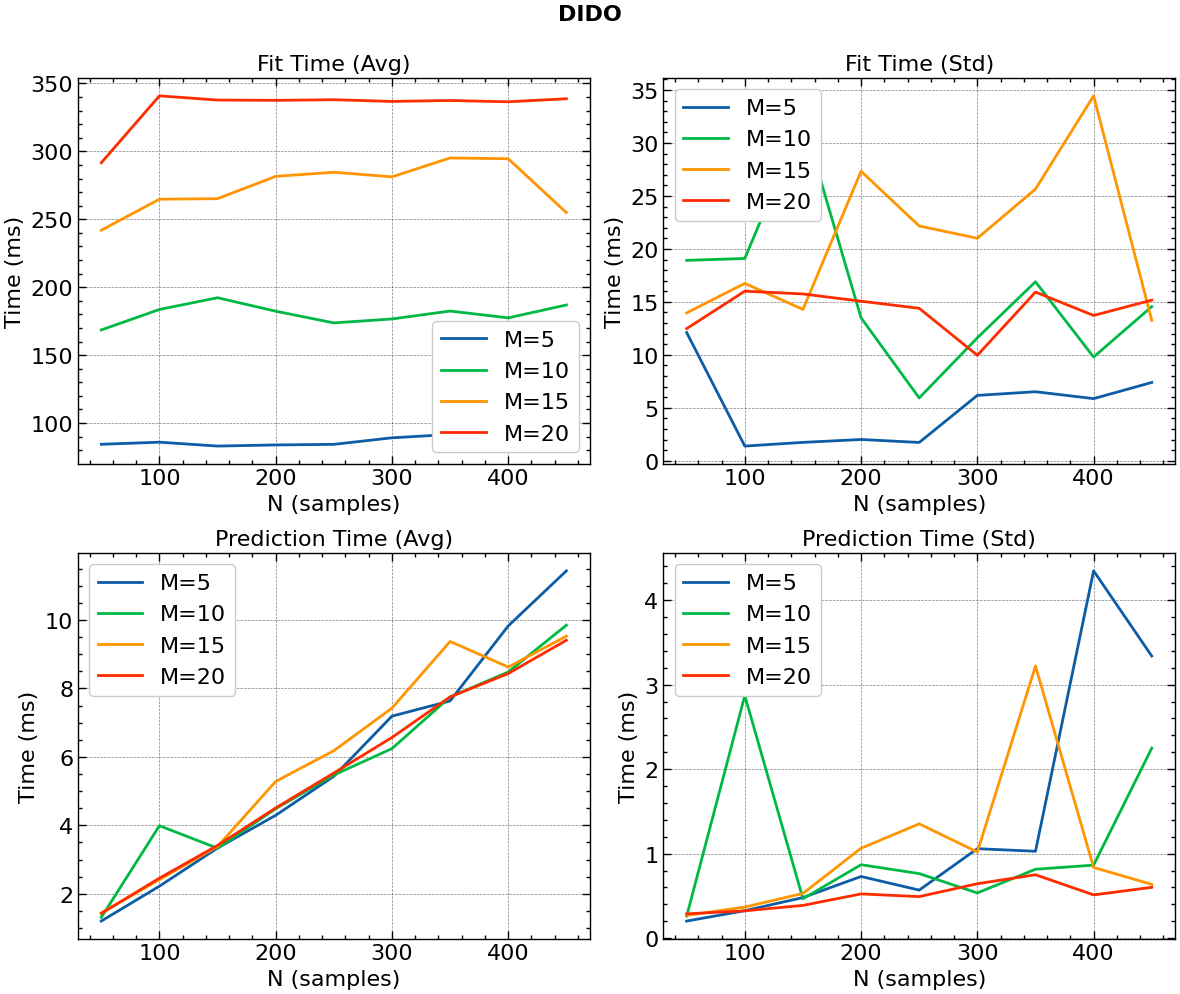

In [7]:
N_list=np.arange(50,500,50)
M_list = np.arange(5,25,5)

DIDO_fit_time_avg,DIDO_fit_time_std,DIDO_pred_time_avg, DIDO_pred_time_std = benchmark_tree(N_list, M_list, target='classfication', feature_is_real=False,num_average_time=25)

plot_results(N_list, M_list, DIDO_fit_time_avg, DIDO_fit_time_std, DIDO_pred_time_avg, DIDO_pred_time_std,title='DIDO')

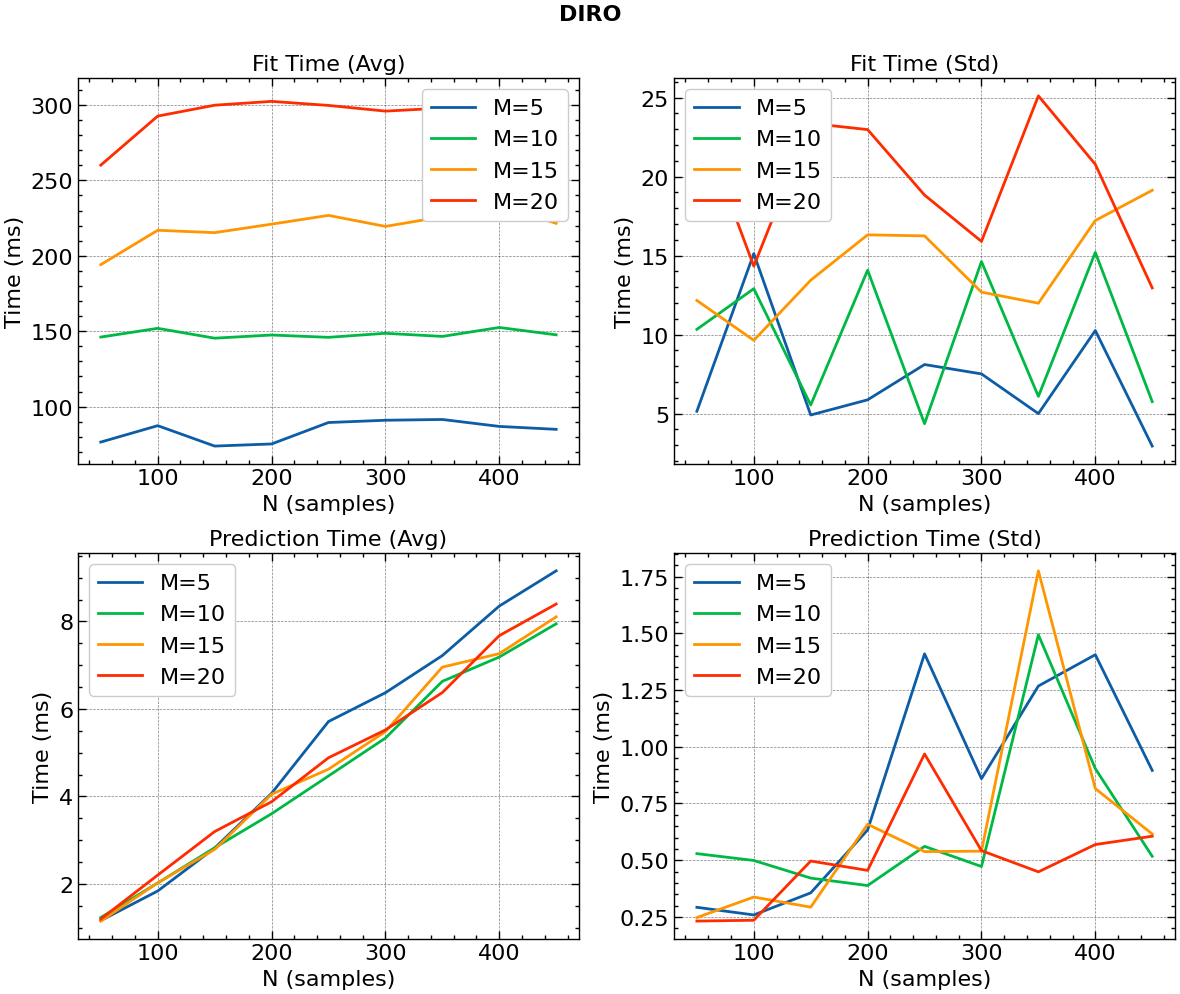

In [11]:
np.random.seed(42)
DIRO_fit_time_avg,DIRO_fit_time_std,DIRO_pred_time_avg, DIRO_pred_time_std = benchmark_tree(N_list, M_list, target='regression', feature_is_real=False,num_average_time=25)

plot_results(N_list, M_list, DIRO_fit_time_avg, DIRO_fit_time_std, DIRO_pred_time_avg, DIRO_pred_time_std,title='DIRO')

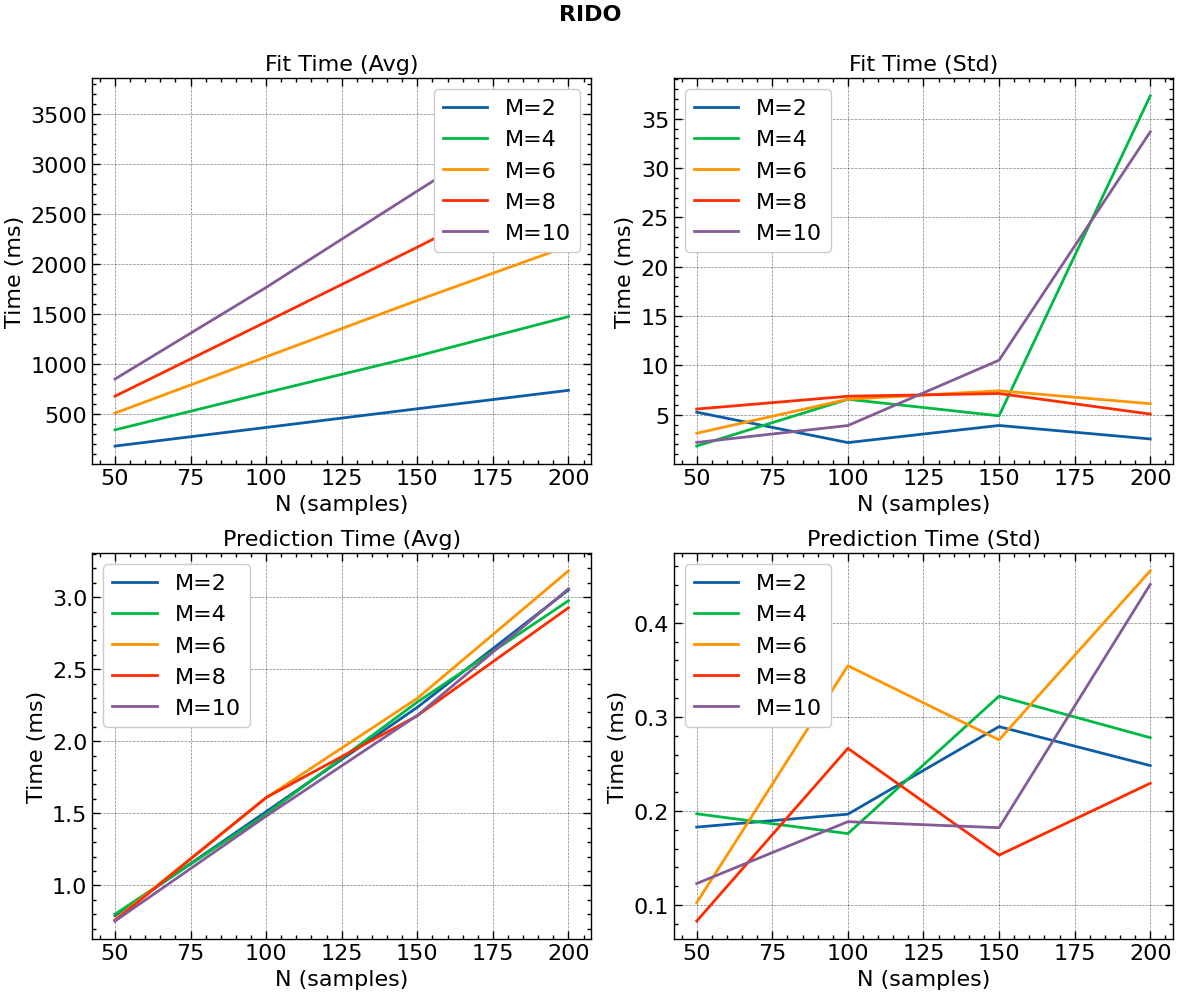

In [14]:
N_list=np.arange(50,201,50)
M_list = np.arange(2,11,2)

RIDO_fit_time_avg,RIDO_fit_time_std,RIDO_pred_time_avg, RIDO_pred_time_std = benchmark_tree(N_list, M_list, target='classfication', feature_is_real=True,num_average_time=10)

plot_results(N_list, M_list, RIDO_fit_time_avg, RIDO_fit_time_std, RIDO_pred_time_avg, RIDO_pred_time_std,title='RIDO')

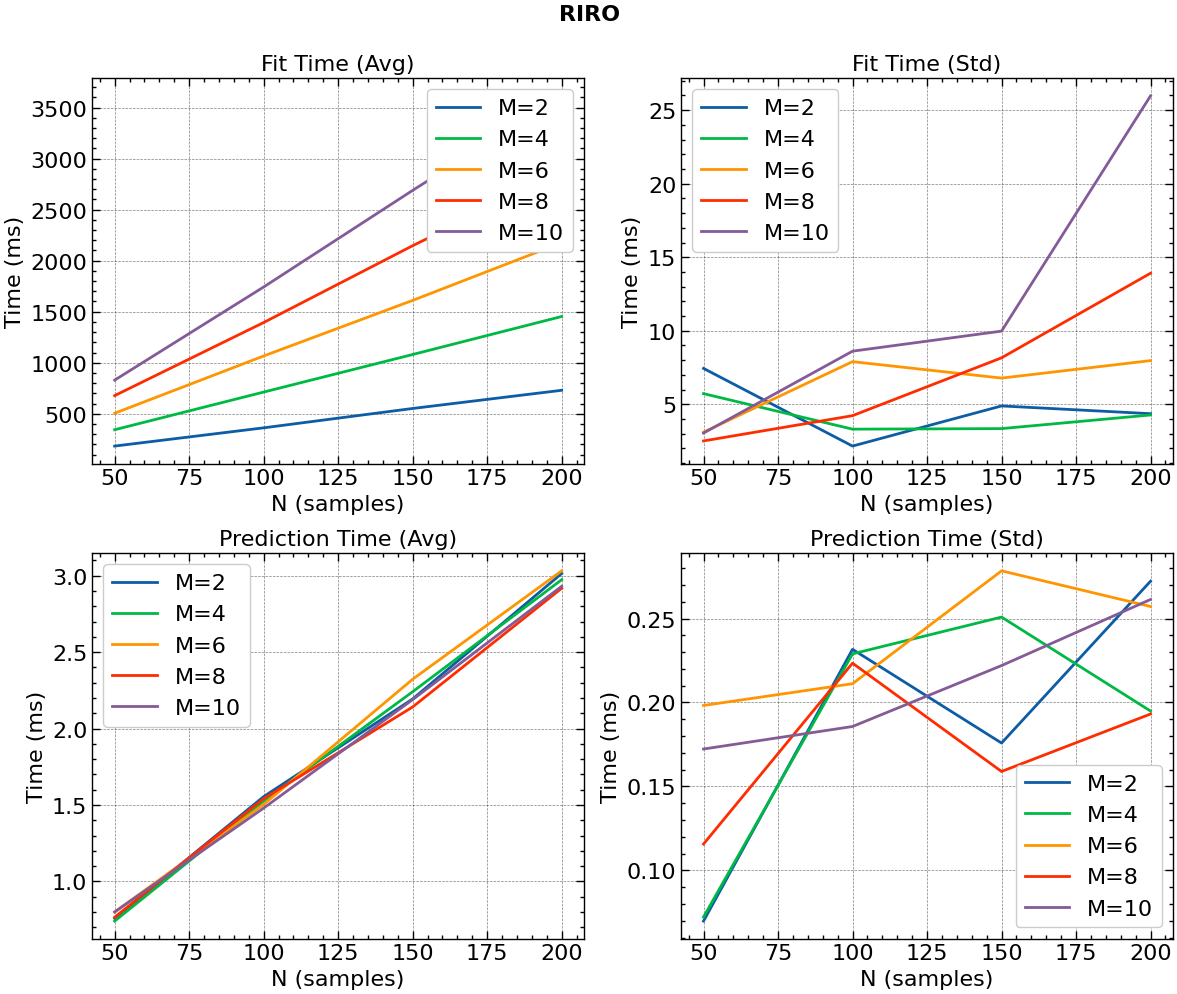

In [15]:
RIRO_fit_time_avg,RIRO_fit_time_std,RIRO_pred_time_avg, RIRO_pred_time_std = benchmark_tree(N_list, M_list, target='regression', feature_is_real=True,num_average_time=10)

plot_results(N_list, M_list, RIRO_fit_time_avg, RIRO_fit_time_std, RIRO_pred_time_avg, RIRO_pred_time_std,title='RIRO')